# A Comparison of Multilayer Perceptrons and Recurrent Neural Networks as Applied to Sentiment Classification

In [324]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
from torchtext.legacy import data
import random
from datetime import datetime
import optuna
import dill

In [325]:
#Ensuring reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True 

## Preparing the Data

In [326]:
# defining the tokeniser and text and label fields
token = nltk.RegexpTokenizer(r'[a-zA-Z]+') # letters only
TEXT = data.Field(tokenize=token.tokenize, lower=True, batch_first=True, include_lengths=True)
LABEL = data.LabelField(dtype = torch.float, batch_first=True)
fields = [('text',TEXT),('label', LABEL)]

In [327]:
# loading the dataset and printing a few entries to check it loaded properly
total_data = data.TabularDataset(path = "total_data.tsv", format = 'tsv', fields = fields)
print([vars(total_data.examples[i]) for i in range(5)])

[{'text': ['so', 'there', 'is', 'no', 'way', 'for', 'me', 'to', 'plug', 'it', 'in', 'here', 'in', 'the', 'us', 'unless', 'i', 'go', 'by', 'a', 'converter'], 'label': '0'}, {'text': ['good', 'case', 'excellent', 'value'], 'label': '1'}, {'text': ['great', 'for', 'the', 'jawbone'], 'label': '1'}, {'text': ['tied', 'to', 'charger', 'for', 'conversations', 'lasting', 'more', 'than', 'minutes', 'major', 'problems'], 'label': '0'}, {'text': ['the', 'mic', 'is', 'great'], 'label': '1'}]


In [357]:
pos = 0
for i in range(len(total_data)):
    label = vars(total_data.examples[i])['label']
    pos += int(label)
pos, len(total_data)-pos

(1386, 1362)

In [371]:
lens = []
for i in range(len(total_data)):
    text = vars(total_data.examples[i])['text']
    lens.append(len(text))
    
lens = np.array(lens)
np.mean(lens), np.std(lens), np.max(lens), np.quantile(lens, 0.01), np.quantile(lens, 0.25), np.quantile(lens, 0.75)

(13.148471615720524, 34.23620443581023, 1319, 2.0, 6.0, 16.0)

In [328]:
# splitting the data into testing, validation, and training sets in the ratio 80% 10% 10%
train_data, valid_data, test_data = total_data.split(split_ratio=[0.8, 0.1, 0.1], random_state = random.seed(SEED))
print(f"Total entries: {len(total_data)}, Training: {len(train_data)}, Validation: {len(valid_data)}, Test: {len(test_data)}")

Total entries: 2748, Training: 2198, Validation: 275, Test: 275


In [342]:
# saving the test data and fields for runs later
torch.save(test_data.examples, "test_data_examples.pkl", pickle_module=dill)

# saving train data examples so vocab can be built later 
torch.save(train_data.examples, "train_data_examples.pkl", pickle_module=dill)

In [330]:
# Building the vocabulary
TEXT.build_vocab(train_data, min_freq=3) # A word has to appear a minimum of 3 times to be included, or it is marked unknown
LABEL.build_vocab(train_data)
vocab_size = len(TEXT.vocab)
print(f"Vocab Size: {vocab_size}")

Vocab Size: 1268


## Defining the Models: MLP and RNN

In [7]:
# MLP with an embedding layer and 2 hidden layers
class MLP(nn.Module):
    def __init__(self, vocab_dim, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_dim, embed_dim, padding_idx=1)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid() # Sigmoid activation because the classification is binary
        
    def forward(self, text, text_lengths):
        embeds = self.embedding(text)
        X = self.relu(self.fc1(embeds))
        X = self.relu(self.fc2(X))
        X = self.sig(self.output(X))
        return X

In [8]:
# RNN with embedding layer, variable number of rnn layers, 1 fully connected hidden layer, 1 fully connected output layer
class RNN(nn.Module):
    def __init__(self, vocab_dim, embed_dim, rnn_hidden_dim, fc_hidden_dim, output_dim, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_dim, embed_dim, padding_idx=1)
        
        self.rnn = nn.RNN(input_size = embed_dim, 
                    hidden_size = rnn_hidden_dim,
                    num_layers=num_layers,
                    batch_first = True)

        self.fc1 = nn.Linear(rnn_hidden_dim, fc_hidden_dim)

        self.relu = nn.ReLU()

        self.fc2 = nn.Linear(fc_hidden_dim, output_dim)

        self.sig = nn.Sigmoid()

    def forward(self, text, text_lengths):
        emb = self.embedding(text)
        X = nn.utils.rnn.pack_padded_sequence(emb, text_lengths, enforce_sorted=False, batch_first=True)
        X, hidden = self.rnn(X)
        X = hidden[-1, :, :]
        X = self.fc1(X)
        X = self.relu(X)
        X = self.fc2(X)
        X = self.sig(X)
        return X

## Training and Evaluation Functions

In [10]:
# defining the accuracy
def accuracy(preds, targets):
    preds_int = torch.round(preds) # rounding predictions
    correct = (preds_int == targets).float() # counting correct predictions
    acc = correct.sum() / len(correct)
    return acc

In [11]:
def train_eval(model, learning_rate=0.001):

    batch_size = 8
    
    train_iterator, valid_iterator = data.BucketIterator.splits(
        (train_data, valid_data), 
        batch_size = batch_size,
        sort_key = lambda x: len(x.text),
        sort_within_batch=True)

    criterion = nn.BCELoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

    epoch_train_loss = 0
    epoch_train_acc = 0
    
    model.train()
    
    for batch in train_iterator:
        
        optimiser.zero_grad()   
        
        text, text_lengths = batch.text   
        
        predictions = model(text, text_lengths).squeeze()

        loss = criterion(predictions, batch.label)
        acc = accuracy(predictions, batch.label)
    
        loss.backward()       
            
        optimiser.step()      
            
        epoch_train_loss += loss.item()  
        epoch_train_acc += acc.item()  

    epoch_valid_loss = 0
    epoch_valid_acc = 0

    model.eval()
    
    with torch.no_grad():
    
        for batch in valid_iterator:
        
            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze()
            
            loss = criterion(predictions, batch.label)
            acc = accuracy(predictions, batch.label)
            
            epoch_valid_loss += loss.item()
            epoch_valid_acc += acc.item()
            

    loss_acc = (epoch_train_loss / len(train_iterator), epoch_train_acc / len(train_iterator), 
                epoch_valid_loss / len(valid_iterator), epoch_valid_acc / len(valid_iterator))
                        
    return loss_acc

In [12]:
def test(model):

    test_iterator = data.BucketIterator(
        test_data, 
        batch_size = 8,
        sort_key = lambda x: len(x.text),
        sort_within_batch=True)

    criterion = nn.BCELoss()
    
    test_loss = 0
    test_acc = 0

    model.eval()
    
    with torch.no_grad():
    
        for batch in test_iterator:
        
            #retrieve review and its length
            text, text_lengths = batch.text

            if text_lengths.all() > 0: # ignore empty reviews
                
                # predicting test data labels
                predictions = model(text, text_lengths).squeeze()
                
                # calculating loss and accuracy
                loss = criterion(predictions, batch.label)
                acc = accuracy(predictions, batch.label)
                
                test_loss += loss.item()
                test_acc += acc.item()

    loss_acc = (test_loss / len(test_iterator), test_acc / len(test_iterator))
    return  loss_acc

In [263]:
def run_training(model, epochs=100, learning_rate=0.001):

    best_valid_loss = float('inf')
    
    train_loss_list = []
    train_acc_list = []
    valid_loss_list = []
    valid_acc_list = []

    for epoch in range(epochs):

        #training the model
        train_loss, train_acc, valid_loss, valid_acc = train_eval(model, learning_rate)
        
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)

        #save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            now = datetime.now().strftime("%d-%m-%Y_%H-%M")
            torch.save(model.state_dict(), f'saved_weights_{now}.pt')
        
        print(f'\tTrain Loss: {train_loss:.3f} \t Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} \t  Val. Acc: {valid_acc*100:.2f}%')

    fig, (ax1, ax2) = plt.subplots(2,1, figsize = (5*1.61, 5*2))
    ax1.plot(train_loss_list, label = "Training Loss")
    ax1.plot(valid_loss_list, label = "Validation Loss")
    ax1.set_ylabel("Loss")
    ax2.set_xlabel("Epoch")
    ax1.grid()
    ax1.legend()
    
    ax2.plot(train_acc_list, label = "Training Accuracy")
    ax2.plot(valid_acc_list, label = "Validation Accuracy")
    ax2.set_ylabel("Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.grid()
    ax2.legend()
    #plt.show()
    
    return train_loss, train_acc, valid_loss, valid_acc

## Running some benchmark models (no tuning)

In [254]:
vocab_dim = len(TEXT.vocab)
embed_dim = 128
hidden_dim = 32
output_dim = 1

mlp = MLP(vocab_dim, embed_dim, hidden_dim, output_dim)

In [255]:
num_layers = 2
rnn = RNN(vocab_dim, embed_dim, hidden_dim, hidden_dim, output_dim, num_layers)

	Train Loss: 0.654 	 Train Acc: 60.77%
	 Val. Loss: 0.589 	  Val. Acc: 64.76%
	Train Loss: 0.494 	 Train Acc: 75.05%
	 Val. Loss: 0.562 	  Val. Acc: 68.69%
	Train Loss: 0.410 	 Train Acc: 80.09%
	 Val. Loss: 0.551 	  Val. Acc: 75.48%
	Train Loss: 0.344 	 Train Acc: 84.24%
	 Val. Loss: 0.551 	  Val. Acc: 79.76%
	Train Loss: 0.291 	 Train Acc: 87.65%
	 Val. Loss: 0.562 	  Val. Acc: 80.12%
	Train Loss: 0.245 	 Train Acc: 89.79%
	 Val. Loss: 0.574 	  Val. Acc: 81.79%
	Train Loss: 0.204 	 Train Acc: 91.61%
	 Val. Loss: 0.595 	  Val. Acc: 82.14%
	Train Loss: 0.172 	 Train Acc: 93.52%
	 Val. Loss: 0.616 	  Val. Acc: 81.43%
	Train Loss: 0.144 	 Train Acc: 94.79%
	 Val. Loss: 0.940 	  Val. Acc: 81.43%
	Train Loss: 0.122 	 Train Acc: 95.92%
	 Val. Loss: 0.993 	  Val. Acc: 81.79%


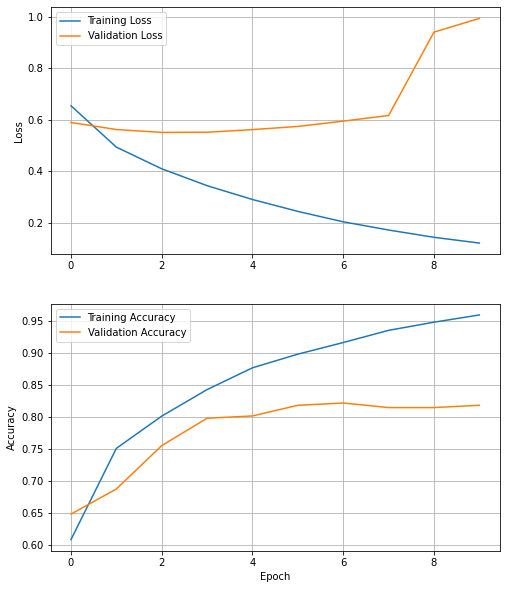

(0.12178760983836996,
 0.9592424243146723,
 0.9927420927477735,
 0.8178571428571428)

In [256]:
run_training(mlp,epochs=10)

	Train Loss: 0.681 	 Train Acc: 55.52%
	 Val. Loss: 0.689 	  Val. Acc: 55.83%
	Train Loss: 0.556 	 Train Acc: 71.59%
	 Val. Loss: 0.579 	  Val. Acc: 70.36%
	Train Loss: 0.426 	 Train Acc: 81.59%
	 Val. Loss: 0.585 	  Val. Acc: 74.05%
	Train Loss: 0.338 	 Train Acc: 86.39%
	 Val. Loss: 0.569 	  Val. Acc: 75.71%
	Train Loss: 0.276 	 Train Acc: 88.91%
	 Val. Loss: 0.562 	  Val. Acc: 75.00%
	Train Loss: 0.214 	 Train Acc: 91.76%
	 Val. Loss: 0.632 	  Val. Acc: 73.33%
	Train Loss: 0.183 	 Train Acc: 93.32%
	 Val. Loss: 0.561 	  Val. Acc: 78.57%
	Train Loss: 0.126 	 Train Acc: 95.95%
	 Val. Loss: 0.695 	  Val. Acc: 77.86%
	Train Loss: 0.105 	 Train Acc: 96.95%
	 Val. Loss: 0.719 	  Val. Acc: 79.64%
	Train Loss: 0.087 	 Train Acc: 97.50%
	 Val. Loss: 0.768 	  Val. Acc: 80.71%


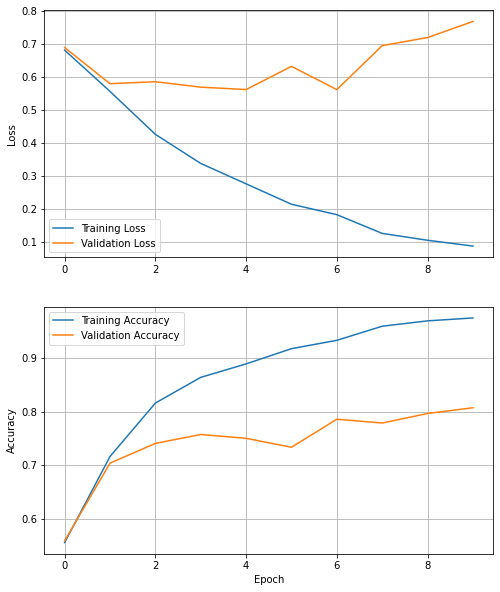

(0.08741246146001769, 0.975, 0.7680427361944956, 0.8071428571428572)

In [257]:
run_training(rnn, epochs=10)

## Hyperparameter tuning

In [258]:
def objective_mlp(trial):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'embed_dim': trial.suggest_int('embed_dim', 180, 200, 5),
              'hidden_dim': trial.suggest_int('hidden_dim', 100, 150, 5),
              }
    
    vocab_dim = len(TEXT.vocab)
    embed_dim = params['embed_dim']
    hidden_dim = params['hidden_dim']
    output_dim = 1

    mlp = MLP(vocab_dim, embed_dim, hidden_dim, output_dim)
    
    train_loss, train_acc, valid_loss, valid_acc = run_training(model=mlp, epochs=10, learning_rate=params['learning_rate'])

    return valid_acc

In [259]:
def objective_rnn(trial):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'embed_dim': trial.suggest_int('embed_dim', 150, 250, 10),
              'hidden_dim': trial.suggest_int('hidden_dim', 50, 150, 10),
              'hidden_dim2': trial.suggest_int('hidden_dim2', 130, 190, 10),
              'num_layers': trial.suggest_int('num_layers', 1, 2),
              }
 
    vocab_dim = len(TEXT.vocab)
    embed_dim = params['embed_dim']
    rnn_hidden_dim = params['hidden_dim']
    fc_hidden_dim = params['hidden_dim2']
    output_dim = 1
    num_layers = params['num_layers']

    rnn = RNN(vocab_dim, embed_dim, rnn_hidden_dim, fc_hidden_dim, output_dim, num_layers)

    train_loss, train_acc, valid_loss, valid_acc = run_training(model=rnn, epochs=10, learning_rate=params['learning_rate'])

    return valid_acc

In [ ]:
# output of this cell has been cleared because it was very long
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective_mlp, n_trials=100)

In [70]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

learning_rate: 0.003926814276309154
embed_dim: 195
hidden_dim: 150


In [ ]:
# output of this cell has been cleared because it was very long
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective_rnn, n_trials=100)

In [17]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

learning_rate: 0.00258965493300806
embed_dim: 230
hidden_dim: 90
hidden_dim2: 150
num_layers: 2


## Training with Best Hyperparams

In [265]:
# Manually imputting the values found by optuna
vocab_dim = len(TEXT.vocab)
embed_dim_mlp = 195
hidden_dim_mlp = 150
output_dim = 1
learning_rate_mlp = 0.003927 

mlp = MLP(vocab_dim, embed_dim_mlp, hidden_dim_mlp, output_dim)

In [266]:
embed_dim_rnn = 230
hidden_dim_rnn = 90
hidden_dim2_rnn =150
num_layers = 2
learning_rate_rnn = 0.002590

rnn = RNN(vocab_dim, embed_dim_rnn, hidden_dim_rnn, hidden_dim2_rnn, output_dim, num_layers)

	Train Loss: 0.600 	 Train Acc: 65.89%
	 Val. Loss: 0.598 	  Val. Acc: 67.98%
	Train Loss: 0.427 	 Train Acc: 80.41%
	 Val. Loss: 0.596 	  Val. Acc: 72.98%
	Train Loss: 0.326 	 Train Acc: 86.09%
	 Val. Loss: 0.653 	  Val. Acc: 75.12%
	Train Loss: 0.235 	 Train Acc: 90.64%
	 Val. Loss: 1.050 	  Val. Acc: 74.76%
	Train Loss: 0.162 	 Train Acc: 93.45%
	 Val. Loss: 1.124 	  Val. Acc: 76.90%
	Train Loss: 0.118 	 Train Acc: 95.32%
	 Val. Loss: 1.151 	  Val. Acc: 78.69%
	Train Loss: 0.087 	 Train Acc: 96.61%
	 Val. Loss: 1.333 	  Val. Acc: 76.19%
	Train Loss: 0.074 	 Train Acc: 97.64%
	 Val. Loss: 2.090 	  Val. Acc: 78.57%
	Train Loss: 0.071 	 Train Acc: 97.86%
	 Val. Loss: 1.986 	  Val. Acc: 81.07%
	Train Loss: 0.074 	 Train Acc: 97.73%
	 Val. Loss: 1.901 	  Val. Acc: 77.98%


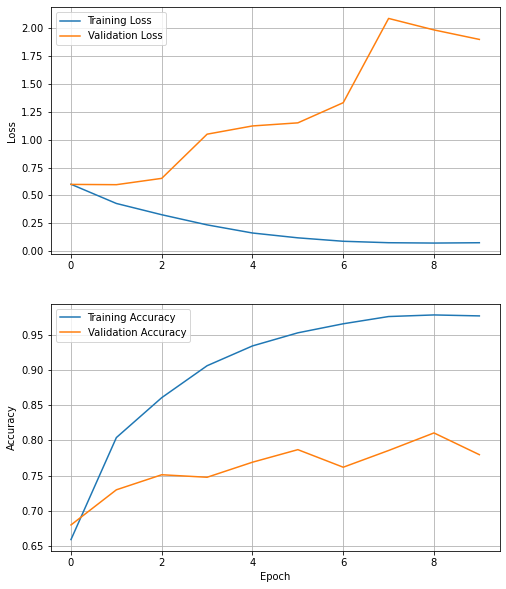

In [267]:
train_loss_mlp, train_acc_mlp, valid_loss_mlp, valid_acc_mlp = run_training(mlp,epochs=10)

	Train Loss: 0.673 	 Train Acc: 55.71%
	 Val. Loss: 0.631 	  Val. Acc: 60.83%
	Train Loss: 0.523 	 Train Acc: 73.58%
	 Val. Loss: 0.603 	  Val. Acc: 66.90%
	Train Loss: 0.380 	 Train Acc: 82.42%
	 Val. Loss: 0.650 	  Val. Acc: 67.86%
	Train Loss: 0.278 	 Train Acc: 88.67%
	 Val. Loss: 0.602 	  Val. Acc: 72.86%
	Train Loss: 0.215 	 Train Acc: 91.56%
	 Val. Loss: 0.720 	  Val. Acc: 73.21%
	Train Loss: 0.169 	 Train Acc: 93.30%
	 Val. Loss: 0.746 	  Val. Acc: 74.64%
	Train Loss: 0.130 	 Train Acc: 95.73%
	 Val. Loss: 0.911 	  Val. Acc: 74.29%
	Train Loss: 0.105 	 Train Acc: 96.14%
	 Val. Loss: 1.001 	  Val. Acc: 75.36%
	Train Loss: 0.077 	 Train Acc: 97.27%
	 Val. Loss: 1.203 	  Val. Acc: 73.57%
	Train Loss: 0.077 	 Train Acc: 97.14%
	 Val. Loss: 1.277 	  Val. Acc: 75.12%


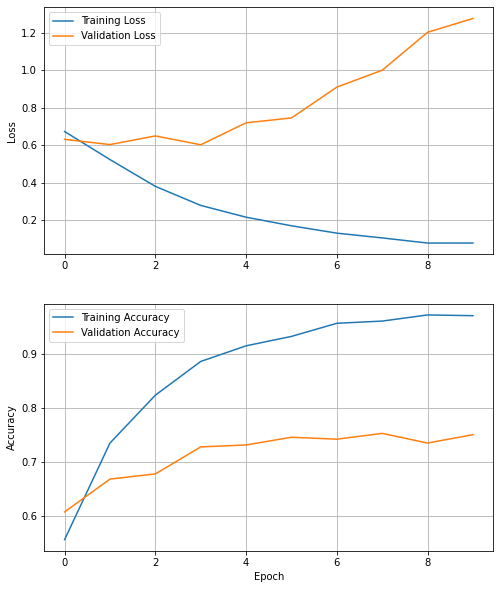

In [268]:
train_loss_rnn, train_acc_rnn, valid_loss_rnn, valid_acc_rnn = run_training(rnn,epochs=10)

## Testing Final Models 
### Cells below here can be run independently of the rest of the notebook to test the best trained models

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.legacy import data
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import dill
import nltk

In [10]:
# MLP with an embedding layer and 2 hidden layers
class MLP(nn.Module):
    def __init__(self, vocab_dim, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_dim, embed_dim, padding_idx=1)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid() # Sigmoid activation because the classification is binary
        
    def forward(self, text, text_lengths):
        embeds = self.embedding(text)
        X = self.relu(self.fc1(embeds))
        X = self.relu(self.fc2(X))
        X = self.sig(self.output(X))
        return X

# RNN with embedding layer, variable number of rnn layers, 1 fully connected hidden layer, 1 fully connected output layer
class RNN(nn.Module):
    def __init__(self, vocab_dim, embed_dim, rnn_hidden_dim, fc_hidden_dim, output_dim, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_dim, embed_dim, padding_idx=1)
        
        self.rnn = nn.RNN(input_size = embed_dim, 
                    hidden_size = rnn_hidden_dim,
                    num_layers=num_layers,
                    batch_first = True)

        self.fc1 = nn.Linear(rnn_hidden_dim, fc_hidden_dim)

        self.relu = nn.ReLU()

        self.fc2 = nn.Linear(fc_hidden_dim, output_dim)

        self.sig = nn.Sigmoid()

    def forward(self, text, text_lengths):
        emb = self.embedding(text)
        X = nn.utils.rnn.pack_padded_sequence(emb, text_lengths, enforce_sorted=False, batch_first=True)
        X, hidden = self.rnn(X)
        X = hidden[-1, :, :]
        X = self.fc1(X)
        X = self.relu(X)
        X = self.fc2(X)
        X = self.sig(X)
        return X

In [13]:
# defining the accuracy
def accuracy(preds, targets):
    preds_int = torch.round(preds) # rounding predictions
    correct = (preds_int == targets).float() # counting correct predictions
    acc = correct.sum() / len(correct)
    return acc

def test(model):
    # defining the tokeniser and text and label fields
    token = nltk.RegexpTokenizer(r'[a-zA-Z]+') # letters only
    TEXT = data.Field(tokenize=token.tokenize, lower=True, batch_first=True, include_lengths=True)
    LABEL = data.LabelField(dtype = torch.float, batch_first=True)
    fields = [('text',TEXT),('label', LABEL)]
    
    # loading test and train data
    test_examples = torch.load("test_data_examples.pkl", pickle_module=dill)
    test_data = data.Dataset(test_examples, fields)
    
    train_data_examples = torch.load("train_data_examples.pkl", pickle_module=dill)
    train_data = data.Dataset(train_data_examples, fields)
    
    # Building the vocabulary
    TEXT.build_vocab(train_data, min_freq=3)
    LABEL.build_vocab(train_data)
    vocab_size = len(TEXT.vocab)
    
    test_iterator = data.BucketIterator(
        test_data, 
        batch_size = 8,
        sort_key = lambda x: len(x.text),
        sort_within_batch=True)

    criterion = nn.BCELoss()
    
    test_loss = 0
    test_acc = 0
    confusion_mat = 0
    model.eval()
    
    with torch.no_grad():
    
        for batch in test_iterator:
        
            #retrieve review and its length
            text, text_lengths = batch.text

            if text_lengths.all() > 0: # ignore empty reviews
                
                # predicting test data labels
                predictions = model(text, text_lengths).squeeze()
                
                # calculating loss and accuracy, confusion matrix
                loss = criterion(predictions, batch.label)
                acc = accuracy(predictions, batch.label)
                c = confusion_matrix(batch.label, torch.round(predictions))
                
                confusion_mat += c
                test_loss += loss.item()
                test_acc += acc.item()
                              
    loss_acc_conf = (test_loss / len(test_iterator), test_acc / len(test_iterator), confusion_mat)
    
    return  loss_acc_conf

In [14]:
vocab_dim = 1268
embed_dim_mlp = 195
hidden_dim_mlp = 150
output_dim = 1
learning_rate_mlp = 0.003927 

mlp = MLP(vocab_dim, embed_dim_mlp, hidden_dim_mlp, output_dim)

mlp.load_state_dict(torch.load("saved_weights_best_mlp.pt"))
# predict
test_loss, test_acc, conf_mat_mlp = test(mlp)
print(f'Test Loss: {test_loss:.3f} \t Test Acc: {test_acc * 100:.2f}%')

Test Loss: 0.515 	 Test Acc: 76.07%


In [15]:
embed_dim_rnn = 230
hidden_dim_rnn = 90
hidden_dim2_rnn =150
num_layers = 2
learning_rate_rnn = 0.002590

rnn = RNN(vocab_dim, embed_dim_rnn, hidden_dim_rnn, hidden_dim2_rnn, output_dim, num_layers)

rnn.load_state_dict(torch.load("saved_weights_best_rnn.pt"))

test_loss, test_acc, conf_mat_rnn = test(rnn)
print(f'Test Loss: {test_loss:.3f} \t Test Acc: {test_acc * 100:.2f}%')

Test Loss: 0.597 	 Test Acc: 64.52%


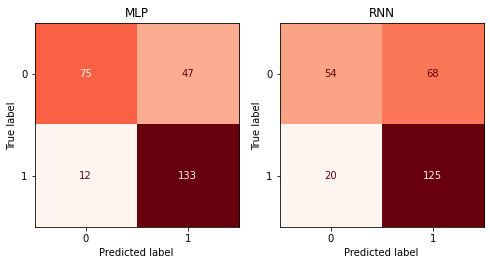

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(5*1.61, 5))

display_mlp = ConfusionMatrixDisplay(conf_mat_mlp)
display_rnn = ConfusionMatrixDisplay(conf_mat_rnn)

display_mlp.plot(cmap='Reds', colorbar=False, ax=ax1)
display_rnn.plot(cmap='Reds', colorbar=False, ax=ax2)

ax1.set_title("MLP")
ax2.set_title("RNN")

plt.show()

In [312]:
def calculate_metrics(conf_mat):
    tn, fp, fn, tp = conf_mat.ravel()
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    f1 = 2 * (p * r) / (p + r)
    print(f"Precision: {p}, Recall: {r}, F1: {f1}")
    
calculate_metrics(conf_mat_mlp)
calculate_metrics(conf_mat_rnn)

Precision: 0.7403314917127072, Recall: 0.9178082191780822, F1: 0.819571865443425
Precision: 0.65625, Recall: 0.863013698630137, F1: 0.7455621301775148


## References

Below are resources I used to help me write my code.

[1]S. Raschka, Y. Liu, V. Mirjalili, and D. Dzhulgakov, Machine learning with PyTorch and Scikit-Learn: develop machine learning and deep learning models with Python. Birmingham: Packt Publishing, 2022.
  
[2]‘Text Classification Pytorch | Build Text Classification Model’, Analytics Vidhya, Jan. 27, 2020. https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/ (accessed May 08, 2022).
  
  
[3]G. Hever, ‘Sentiment Analysis with Pytorch — Part 5— MLP Model’, Medium, Apr. 23, 2020. https://galhever.medium.com/sentiment-analysis-with-pytorch-part-5-mlp-model-387057f4a06a (accessed May 08, 2022).
  
[3]R. Winastwan, ‘Hyperparameter Tuning of Neural Networks with Optuna and PyTorch’, Medium, Dec. 14, 2021. https://towardsdatascience.com/hyperparameter-tuning-of-neural-networks-with-optuna-and-pytorch-22e179efc837 (accessed May 08, 2022).
  

